# Kaggle соревнование

In [111]:
!pip3 install -r requirements.txt
# brew install lightgbm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import root_mean_squared_log_error as RMSLE
from sklearn.ensemble import VotingRegressor, StackingRegressor
from openfe import OpenFE, transform
from optuna.samplers import TPESampler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
import optuna

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_style(style="darkgrid")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
df0 = pd.read_csv("train.csv", delimiter=",")
X_val = pd.read_csv("test.csv", delimiter=",")
df0 = df0.rename(columns={
    "Whole weight": "Whole_weight",
    "Whole weight.1": "Shucked_weight",
    "Whole weight.2": "Viscera_weight",
    "Shell weight": "Shell_weight"
    })

X_val = X_val.rename(columns={
    "Whole weight": "Whole_weight",
    "Whole weight.1": "Shucked_weight",
    "Whole weight.2": "Viscera_weight",
    "Shell weight": "Shell_weight"
    })

df = df0.copy()
df["Rings"] = np.log1p(df["Rings"])
non_cat_features = ["Length", "Diameter", "Height", "Whole_weight", "Shucked_weight", "Viscera_weight", "Shell_weight"]
cat_features = ["Sex"]

df0

id Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
0          0   F   0.550     0.430   0.150        0.7715          0.3285   
1          1   F   0.630     0.490   0.145        1.1300          0.4580   
2          2   I   0.160     0.110   0.025        0.0210          0.0055   
3          3   M   0.595     0.475   0.150        0.9145          0.3755   
4          4   I   0.555     0.425   0.130        0.7820          0.3695   
...      ...  ..     ...       ...     ...           ...             ...   
90610  90610   M   0.335     0.235   0.075        0.1585          0.0685   
90611  90611   M   0.555     0.425   0.150        0.8790          0.3865   
90612  90612   I   0.435     0.330   0.095        0.3215          0.1510   
90613  90613   I   0.345     0.270   0.075        0.2000          0.0980   
90614  90614   I   0.425     0.325   0.100        0.3455          0.1525   

       Viscera_weight  Shell_weight  Rings  
0              0.1465        0.2400     11  
1              0.2765        0.3200     11  
2              0.0030        0.0050      6  
3              0.2055        0.2500     10  
4              0.1600        0.1975      9  
...               ...           ...    ...  
90610          0.0370        0.0450      6  
90611          0.1815        0.2400      9  
90612          0.0785        0.0815      6  
90613          0.0490        0.0700      6  
90614          0.0785        0.1050      8  

[90615 rows x 10 columns]

Всего 9 фичей:

1. **id** - целочисленный - id измерения
2. **Sex** - категориальный - пол (Male/Female/Infant)
3. **Length** - вещественный - максимальный размер раковины (в мм)
4. **Diameter** - вещественный - размер раковины вдоль оси, пермендикулярной оси длины (в мм)
5. **Height** - вещественный - высота раковины (в мм)
6. **Whole weight** - вещественный - полный вес моллюска (в гр)
7. **Shucked_weight** - вещественный - вес мяса моллюска после отделения от раковины (в гр)
8. **Viscera_weight** - вещественный - вес внутренностей моллюска после удаления мяса (в гр)
9. **Shell weight** - вещественный - вес раковины абалона после ее высушивания (в гр)

И таргет

**Rings** - целочисленный - количество колец (если прибавить 1.5, получим возраст моллюска)

Построим зависимости таргета от фичей.

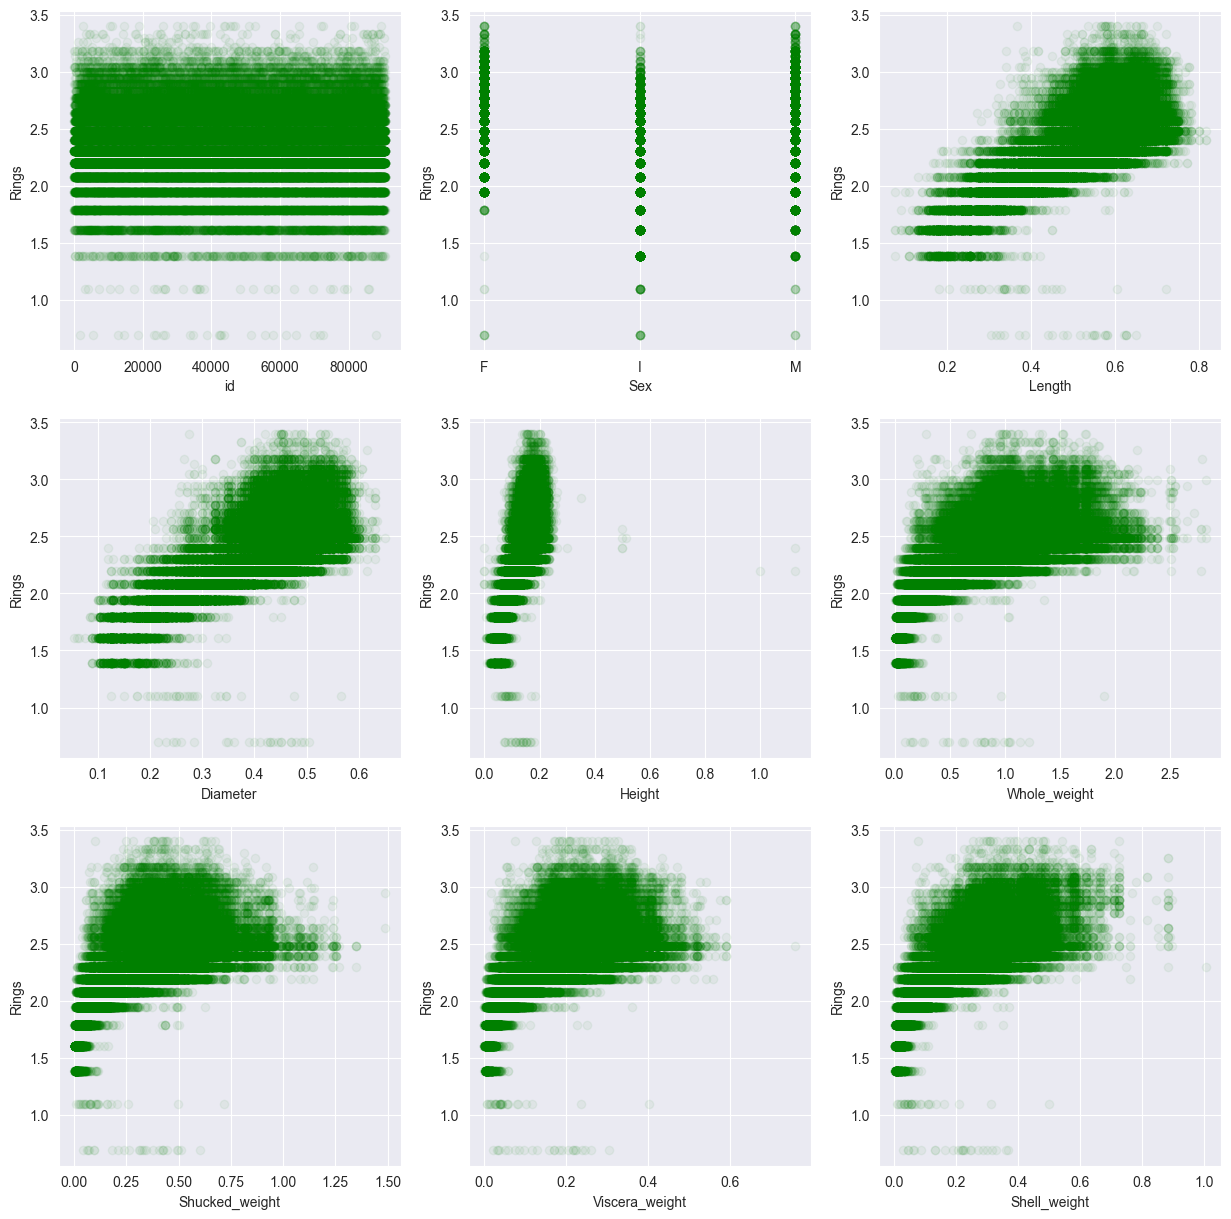

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i, feature in enumerate(df.drop(columns=["Rings"]).columns):
    ax[i//3, i%3].scatter(df[feature], df["Rings"], alpha=0.05, color="green")
    ax[i//3, i%3].set(xlabel=feature, ylabel="Rings")

Видим, что от столбца id зависимости нет, поэтому в дальнейшем не будем его использовать.

<Axes: >

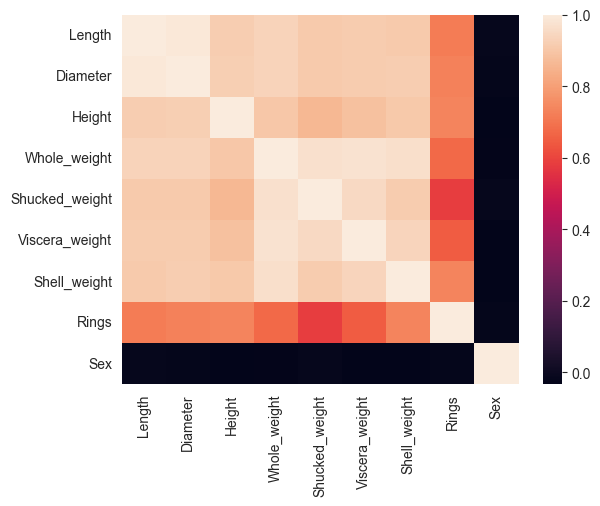

In [5]:
df_order_enc = df.drop(columns=["id", "Sex"])
df_order_enc["Sex"] = np.where(df["Sex"] == "M", 1, np.where(df["Sex"] == "I", 0, -1))

sns.heatmap(df_order_enc.corr())

## Бейслайн

### 1. Проверка на выбросы

In [6]:
pd.DataFrame(df.isna().sum())

0
id              0
Sex             0
Length          0
Diameter        0
Height          0
Whole_weight    0
Shucked_weight  0
Viscera_weight  0
Shell_weight    0
Rings           0

In [7]:
pd.DataFrame(X_val.isna().sum())

0
id              0
Sex             0
Length          0
Diameter        0
Height          0
Whole_weight    0
Shucked_weight  0
Viscera_weight  0
Shell_weight    0

Видим, что пропусков нет, заполнять ничего не нужно

### 2. Проверка на выбросы

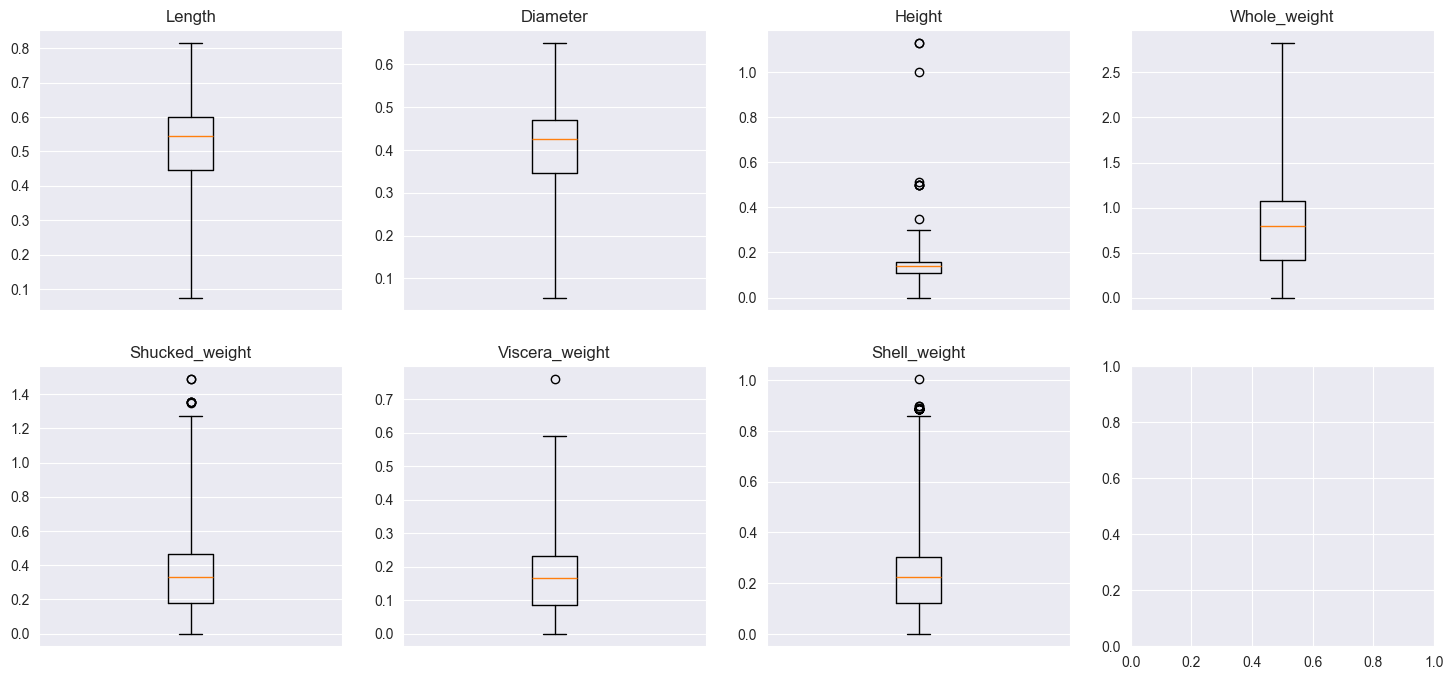

In [ ]:
def check_outliers(_df: pd.DataFrame, whis: int = 3) -> None:
    _, axs = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))

    for i, feature in enumerate(non_cat_features):
        if feature != "Sex":
            axs[i//4, i%4].boxplot(x=_df[feature], whis=whis)
            axs[i//4, i%4].set(title=feature)
            axs[i//4, i%4].get_xaxis().set_visible(False)

    plt.show()

whis = 1.5
check_outliers(df, whis)

В датасете осталось 90570 строк


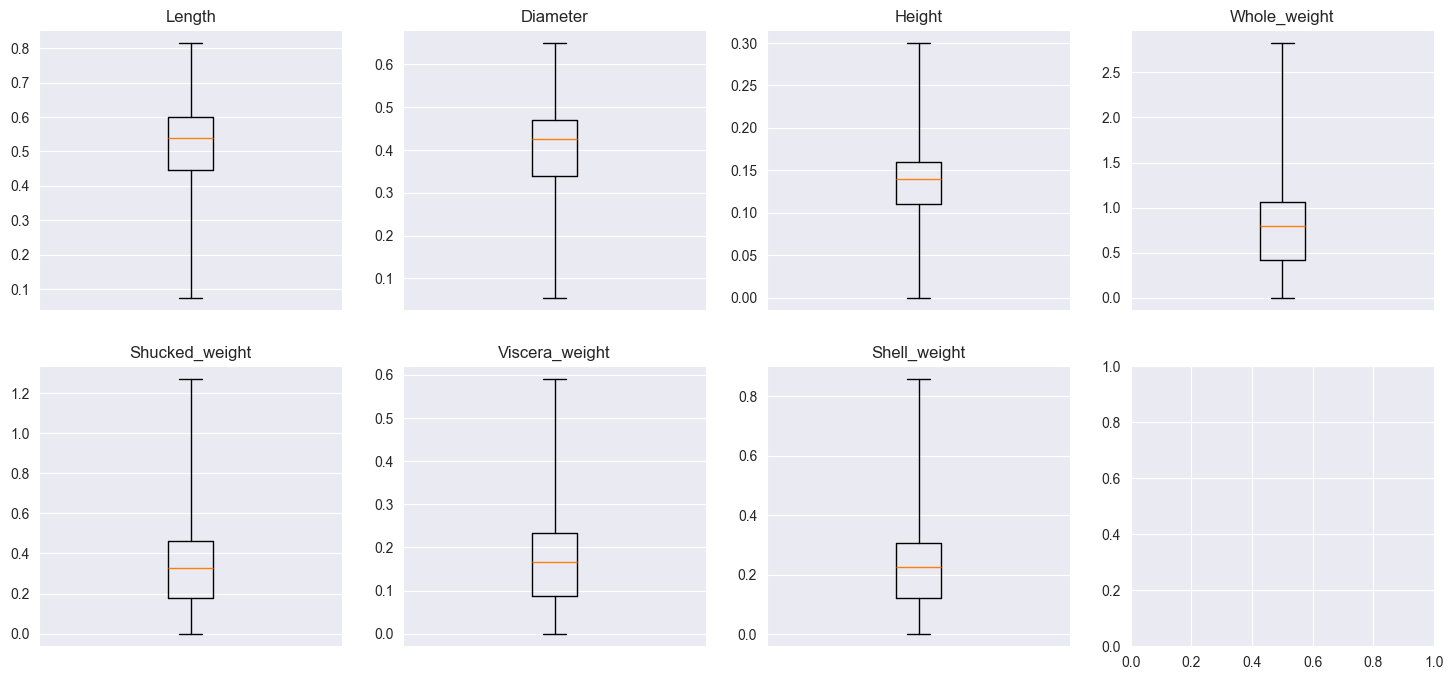

In [9]:
Q1, Q3 = df[non_cat_features].quantile(0.25), df[non_cat_features].quantile(0.75)
IQR = Q3 - Q1
top_lim, bottom_lim = Q3 + whis * IQR, Q1 - whis * IQR

mask = (df[non_cat_features] >= bottom_lim) & (df[non_cat_features] <= top_lim)
df = df[mask.all(axis=1)]

print(f"В датасете осталось {len(df)} строк")
check_outliers(df, whis)

### 3. Кодирование

In [10]:
non_cat_features = ["Length", "Diameter", "Height", "Whole_weight", "Shucked_weight", "Viscera_weight", "Shell_weight"]
cat_features = ["Sex"]

In [ ]:
X_train, y_train = df[non_cat_features + cat_features], df["Rings"]
X_train_CV, X_test_CV, y_train_CV, y_test_CV = train_test_split(X_train, y_train, test_size=0.23)

In [12]:
train_pool = Pool(X_train_CV, label=y_train_CV, cat_features=cat_features)
test_pool = Pool(X_test_CV, label=y_test_CV, cat_features=cat_features)

catboost_model = CatBoostRegressor(
    loss_function="RMSE",
).fit(train_pool)
y_predict = catboost_model.predict(data=X_test_CV)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(y_predict)):.5f}")

Learning rate set to 0.080066
0:	learn: 0.2719301	total: 63.7ms	remaining: 1m 3s
1:	learn: 0.2599212	total: 70.7ms	remaining: 35.3s
2:	learn: 0.2493750	total: 76.9ms	remaining: 25.6s
3:	learn: 0.2401106	total: 81.6ms	remaining: 20.3s
4:	learn: 0.2312916	total: 87ms	remaining: 17.3s
5:	learn: 0.2235715	total: 91.5ms	remaining: 15.2s
6:	learn: 0.2168014	total: 96.1ms	remaining: 13.6s
7:	learn: 0.2105151	total: 101ms	remaining: 12.5s
8:	learn: 0.2053001	total: 106ms	remaining: 11.6s
9:	learn: 0.2002594	total: 111ms	remaining: 11s
10:	learn: 0.1959556	total: 117ms	remaining: 10.5s
11:	learn: 0.1921877	total: 121ms	remaining: 9.99s
12:	learn: 0.1886345	total: 127ms	remaining: 9.62s
13:	learn: 0.1854432	total: 131ms	remaining: 9.22s
14:	learn: 0.1826942	total: 135ms	remaining: 8.87s
15:	learn: 0.1802878	total: 140ms	remaining: 8.59s
16:	learn: 0.1781287	total: 145ms	remaining: 8.37s
17:	learn: 0.1759831	total: 149ms	remaining: 8.14s
18:	learn: 0.1740987	total: 154ms	remaining: 7.94s
19:	lear

In [ ]:
metrics = catboost_model.eval_metrics(test_pool,
                            metrics=["RMSE"],
                            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Генерация и отбор признаков.

In [23]:
ofe = OpenFE()
features = ofe.fit(data=X_train, label=y_train, n_jobs=4, seed=RANDOM_SEED, categorical_features=cat_features)
X_train_FE, X_valid_FE = transform(X_train, X_val, features, n_jobs=4)
X_train_FE

The number of candidate features is 266
Start stage I selection.


  0%|          | 0/16 [00:00<?, ?it/s]/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metric

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

  6%|▋         | 1/16 [00:01<00:22,  1.50s/it]/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 12%|█▎        | 2/16 [00:01<00:09,  1.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to rem

/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 31%|███▏      | 5/16 [00:01<00:02,  4.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no mor

/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 44%|████▍     | 7/16 [00:02<00:01,  5.10it/s]/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 56%|█████▋    | 9/16 [00:02<00:01,  6.92it/s]/Users/shapkapavel/VSCodeProject

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to r

/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 69%|██████▉   | 11/16 [00:02<00:00,  5.96it/s]/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to re

 88%|████████▊ | 14/16 [00:02<00:00,  8.64it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

100%|██████████| 16/16 [00:02<00:00,  5.35it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 9057, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

77 same features have been deleted.
Meet early-stopping in successive feature-wise halving.


  0%|          | 0/16 [00:00<?, ?it/s]/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metric

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to

  6%|▋         | 1/16 [00:03<00:50,  3.36s/it]/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 12%|█▎        | 2/16 [00:03<00:21,  1.51s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to

/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 19%|█▉        | 3/16 [00:03<00:11,  1.10it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 25%|██▌       | 4/16 [00:04<00:07,  1.54it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1


/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to 

 31%|███▏      | 5/16 [00:05<00:10,  1.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` t

/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` t

 50%|█████     | 8/16 [00:06<00:04,  1.77it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to

/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to

 56%|█████▋    | 9/16 [00:07<00:04,  1.49it/s]/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 69%|██████▉   | 11/16 [00:07<00:02,  2.19it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` t

 75%|███████▌  | 12/16 [00:08<00:02,  1.70it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` t

/Users/shapkapavel/VSCodeProjects/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` t

 88%|████████▊ | 14/16 [00:09<00:00,  2.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1


 94%|█████████▍| 15/16 [00:09<00:00,  2.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1


100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

The number of remaining candidate features is 188
Start stage II selection.


100%|██████████| 16/16 [00:04<00:00,  3.86it/s]


Finish data processing.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38529
[LightGBM] [Info] Number of data points in the train set: 72456, number of used features: 196


Length  Diameter  Height  Whole_weight  Shucked_weight  \
openfe_index                                                           
0              0.550     0.430   0.150        0.7715          0.3285   
1              0.630     0.490   0.145        1.1300          0.4580   
2              0.160     0.110   0.025        0.0210          0.0055   
3              0.595     0.475   0.150        0.9145          0.3755   
4              0.555     0.425   0.130        0.7820          0.3695   
...              ...       ...     ...           ...             ...   
90610          0.335     0.235   0.075        0.1585          0.0685   
90611          0.555     0.425   0.150        0.8790          0.3865   
90612          0.435     0.330   0.095        0.3215          0.1510   
90613          0.345     0.270   0.075        0.2000          0.0980   
90614          0.425     0.325   0.100        0.3455          0.1525   

              Viscera_weight  Shell_weight Sex  autoFE_f_0  autoFE_f_1  ...  \
openfe_index                                                            ...   
0                     0.1465        0.2400   F    2.291667      0.3900  ...   
1                     0.2765        0.3200   F    1.968750      0.4650  ...   
2                     0.0030        0.0050   I   32.000000      0.0300  ...   
3                     0.2055        0.2500   M    2.380000      0.4000  ...   
4                     0.1600        0.1975   I    2.810127      0.3275  ...   
...                      ...           ...  ..         ...         ...  ...   
90610                 0.0370        0.0450   M    7.444444      0.1200  ...   
90611                 0.1815        0.2400   M    2.312500      0.3900  ...   
90612                 0.0785        0.0815   I    5.337423      0.1765  ...   
90613                 0.0490        0.0700   I    4.928571      0.1450  ...   
90614                 0.0785        0.1050   I    4.047619      0.2050  ...   

              autoFE_f_178  autoFE_f_179  autoFE_f_180  autoFE_f_181  \
openfe_index                                                           
0                   0.2650      0.422136        0.1465     -1.427116   
1                   0.2500      0.379048        0.2765     -1.139434   
2                   0.0050      0.009096        0.0030     -5.298317   
3                   0.2650      0.422136        0.2055     -1.386294   
4                   0.1955      0.306492        0.1600     -1.622017   
...                    ...           ...           ...           ...   
90610               0.0435      0.062804        0.0370     -3.101093   
90611               0.2650      0.422136        0.1815     -1.427116   
90612               0.0800      0.120651        0.0785     -2.507152   
90613               0.0435      0.062804        0.0490     -2.659260   
90614               0.0950      0.148279        0.0785     -2.253795   

              autoFE_f_182  autoFE_f_183  autoFE_f_184  autoFE_f_185  \
openfe_index                                                           
0                 0.107912        0.2050      0.057600           0.0   
1                 0.209764        0.1835      0.102400           0.0   
2                 0.000030        0.0050      0.000025           0.0   
3                 0.141000        0.2050      0.062500           0.0   
4                 0.136530        0.1475      0.039006           0.0   
...                    ...           ...           ...           ...   
90610             0.004692        0.0315      0.002025           0.0   
90611             0.149382        0.2050      0.057600           0.0   
90612             0.022801        0.0575      0.006642           0.0   
90613             0.009604        0.0315      0.004900           0.0   
90614             0.023256        0.0680      0.011025           0.0   

              autoFE_f_186  autoFE_f_187  
openfe_index                              
0                   0.1465     -1.897120  
1                   0.2765     -1.931022  
2  

In [24]:
cols = X_train_FE.columns
num_cols = X_train_FE._get_numeric_data().columns

feature_cols = list(set(cols) - set(num_cols))
feature_cols.remove("Sex")

X_train_FE = X_train_FE.drop(columns=feature_cols, axis=1)
X_valid_FE = X_valid_FE.drop(columns=feature_cols, axis=1)

X_train_FE[num_cols] = X_train_FE[num_cols].astype(float)
X_valid_FE[num_cols] = X_valid_FE[num_cols].astype(float)

In [25]:
X_train_CVFE, X_test_CVFE, y_train_CV, y_test_CV = train_test_split(X_train_FE, y_train, test_size=0.23)

In [26]:
catboost_model = CatBoostRegressor(
    loss_function="RMSE",
    cat_features=cat_features,
).fit(X_train_CVFE, y_train_CV)
y_predict = catboost_model.predict(data=X_test_CVFE)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(y_predict)):.5f}")

Learning rate set to 0.080066
0:	learn: 0.2701614	total: 14.6ms	remaining: 14.6s
1:	learn: 0.2569717	total: 26.8ms	remaining: 13.3s
2:	learn: 0.2451555	total: 38.1ms	remaining: 12.6s
3:	learn: 0.2343651	total: 49.4ms	remaining: 12.3s
4:	learn: 0.2247406	total: 60.4ms	remaining: 12s
5:	learn: 0.2162705	total: 69.4ms	remaining: 11.5s
6:	learn: 0.2086794	total: 78.6ms	remaining: 11.1s
7:	learn: 0.2019851	total: 89.1ms	remaining: 11s
8:	learn: 0.1959903	total: 101ms	remaining: 11.1s
9:	learn: 0.1907549	total: 111ms	remaining: 10.9s
10:	learn: 0.1859450	total: 122ms	remaining: 11s
11:	learn: 0.1817423	total: 133ms	remaining: 11s
12:	learn: 0.1779786	total: 144ms	remaining: 11s
13:	learn: 0.1745721	total: 156ms	remaining: 11s
14:	learn: 0.1716921	total: 167ms	remaining: 11s
15:	learn: 0.1691093	total: 178ms	remaining: 10.9s
16:	learn: 0.1668690	total: 189ms	remaining: 10.9s
17:	learn: 0.1648293	total: 200ms	remaining: 10.9s
18:	learn: 0.1630295	total: 212ms	remaining: 10.9s
19:	learn: 0.1614

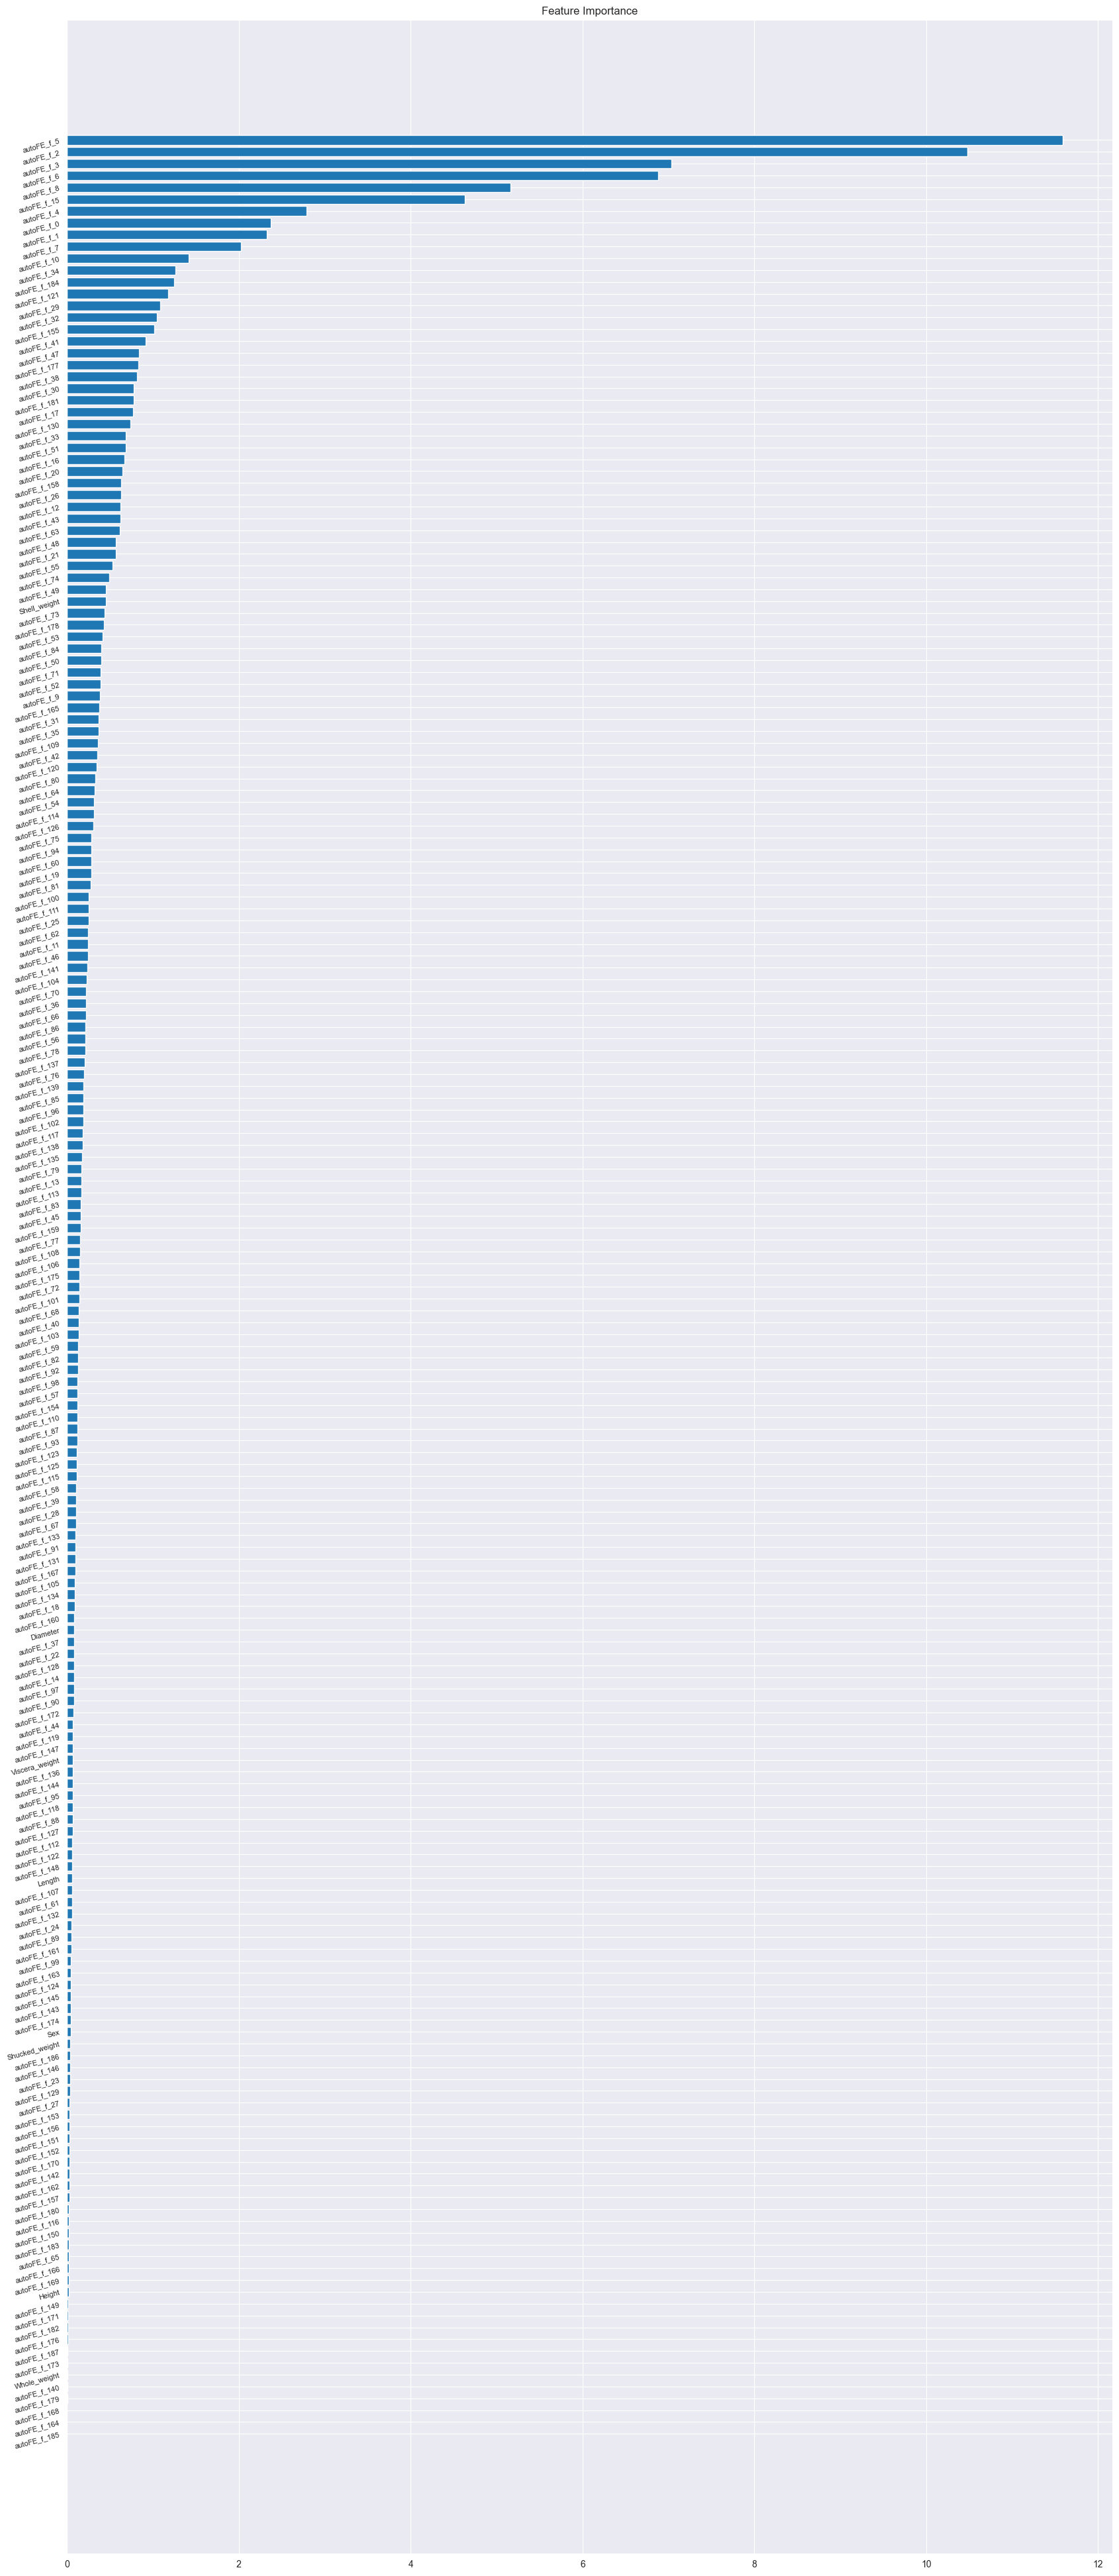

In [27]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(17, len(sorted_idx) * 0.2))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_test_CVFE.columns)[sorted_idx], fontsize=8, rotation=15)
plt.title("Feature Importance")
plt.tight_layout()

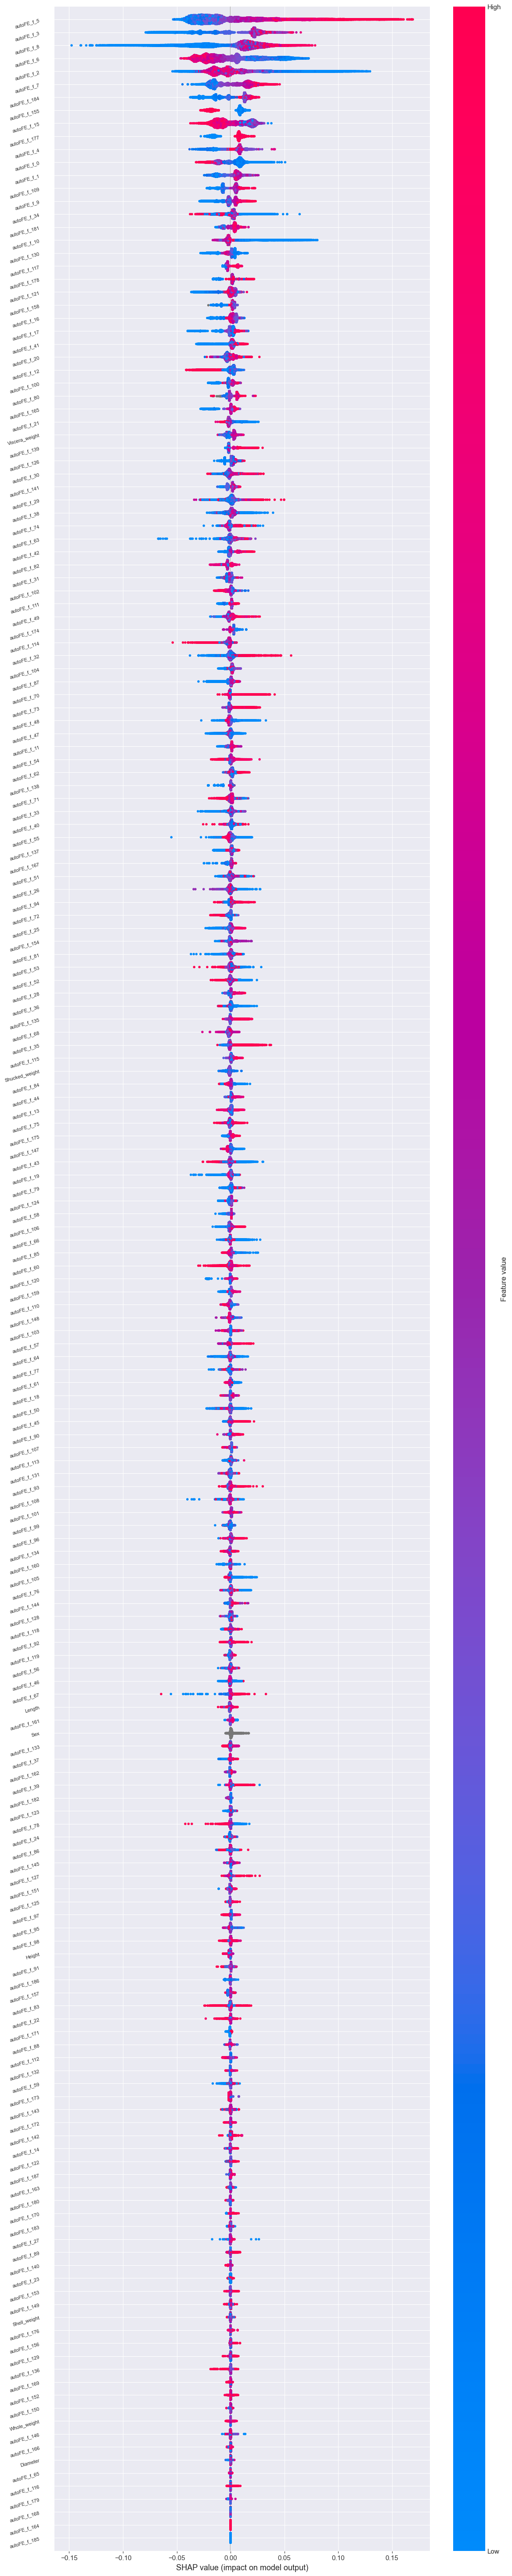

In [29]:
shap_test = shap.TreeExplainer(catboost_model).shap_values(Pool(X_valid_FE.drop(columns=["id"]), cat_features=cat_features))
shap.summary_plot(shap_test, X_valid_FE.drop(columns=["id"]), max_display=X_valid_FE.shape[1], show=False)

plt.gcf().set_size_inches(15, len(sorted_idx) * 0.3)
plt.yticks(fontsize=8, rotation=15)
plt.show()

In [30]:
shap_sum = np.abs(shap_test).mean(axis=0)
importance_df = pd.DataFrame([X_train_FE.columns.to_list(), list(shap_sum)]).T
importance_df.columns = ["col_name", "shap_importance"]
importance_df = importance_df.sort_values("shap_importance", ascending=False)
importance_df

col_name shap_importance
13     autoFE_f_5        0.028746
11     autoFE_f_3        0.025661
16     autoFE_f_8        0.024201
14     autoFE_f_6        0.021464
10     autoFE_f_2        0.015861
..            ...             ...
123  autoFE_f_116        0.000096
186  autoFE_f_179        0.000087
171  autoFE_f_164             0.0
192  autoFE_f_185             0.0
175  autoFE_f_168             0.0

[195 rows x 2 columns]

In [31]:
# cutoff_ind = importance_df.index[importance_df["col_name"] == "autoFE_f_57"].to_list()[0]
cutoff_ind = 40
importance_df = importance_df[:cutoff_ind]
cutoff_ind

40

In [ ]:
X_train_CVFE_proc = X_train_CVFE[importance_df["col_name"]]
X_test_CVFE_proc = X_test_CVFE[importance_df["col_name"]]
X_valid_FE_proc = X_valid_FE[importance_df["col_name"].to_list() + ["id"]]

catboost_model = CatBoostRegressor(
    loss_function="RMSE",
    # cat_features=["Sex"]
).fit(X_train_CVFE_proc, y_train_CV)
y_predict = catboost_model.predict(data=X_test_CVFE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(y_predict)):.5f}")

Learning rate set to 0.080066
0:	learn: 0.2702089	total: 2.94ms	remaining: 2.93s
1:	learn: 0.2570408	total: 6.22ms	remaining: 3.1s
2:	learn: 0.2450087	total: 9.02ms	remaining: 3s
3:	learn: 0.2344049	total: 11.9ms	remaining: 2.97s
4:	learn: 0.2247836	total: 15.4ms	remaining: 3.07s
5:	learn: 0.2162267	total: 18.5ms	remaining: 3.06s
6:	learn: 0.2087286	total: 21.4ms	remaining: 3.04s
7:	learn: 0.2019634	total: 24.2ms	remaining: 3s
8:	learn: 0.1959131	total: 27.1ms	remaining: 2.98s
9:	learn: 0.1905882	total: 30.1ms	remaining: 2.98s
10:	learn: 0.1857303	total: 32.8ms	remaining: 2.95s
11:	learn: 0.1813923	total: 35.9ms	remaining: 2.95s
12:	learn: 0.1776689	total: 39.1ms	remaining: 2.97s
13:	learn: 0.1743006	total: 42ms	remaining: 2.96s
14:	learn: 0.1714775	total: 44.8ms	remaining: 2.94s
15:	learn: 0.1689223	total: 47.9ms	remaining: 2.95s
16:	learn: 0.1667949	total: 50.9ms	remaining: 2.94s
17:	learn: 0.1648767	total: 53.6ms	remaining: 2.93s
18:	learn: 0.1630592	total: 56.8ms	remaining: 2.93s
1

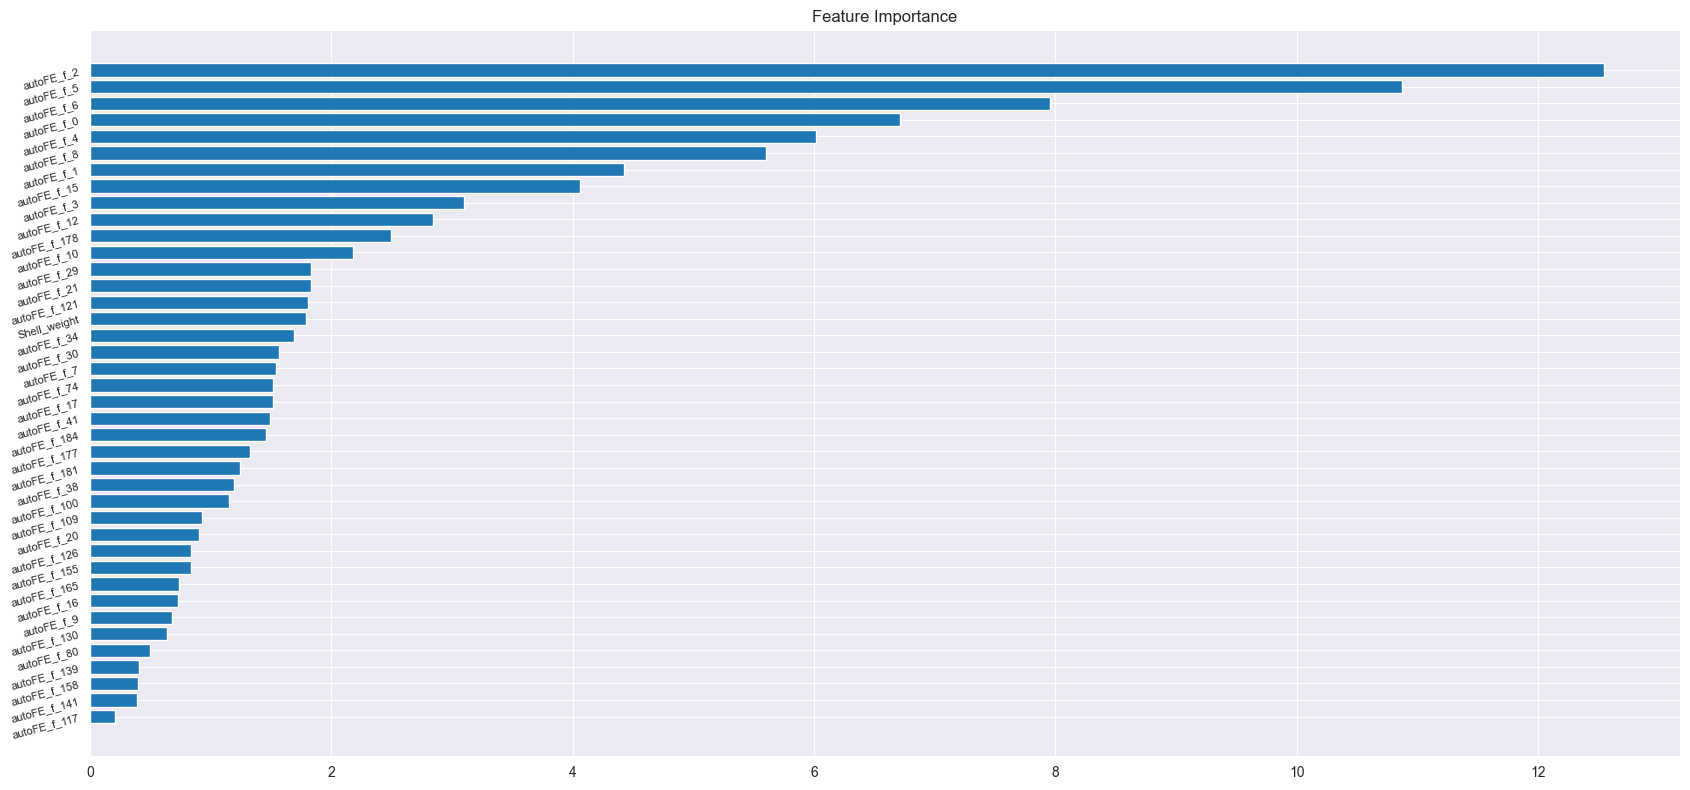

In [33]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(17, len(sorted_idx) * 0.2))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_test_CVFE_proc.columns)[sorted_idx], fontsize=8, rotation=15)
plt.title("Feature Importance")
plt.tight_layout()

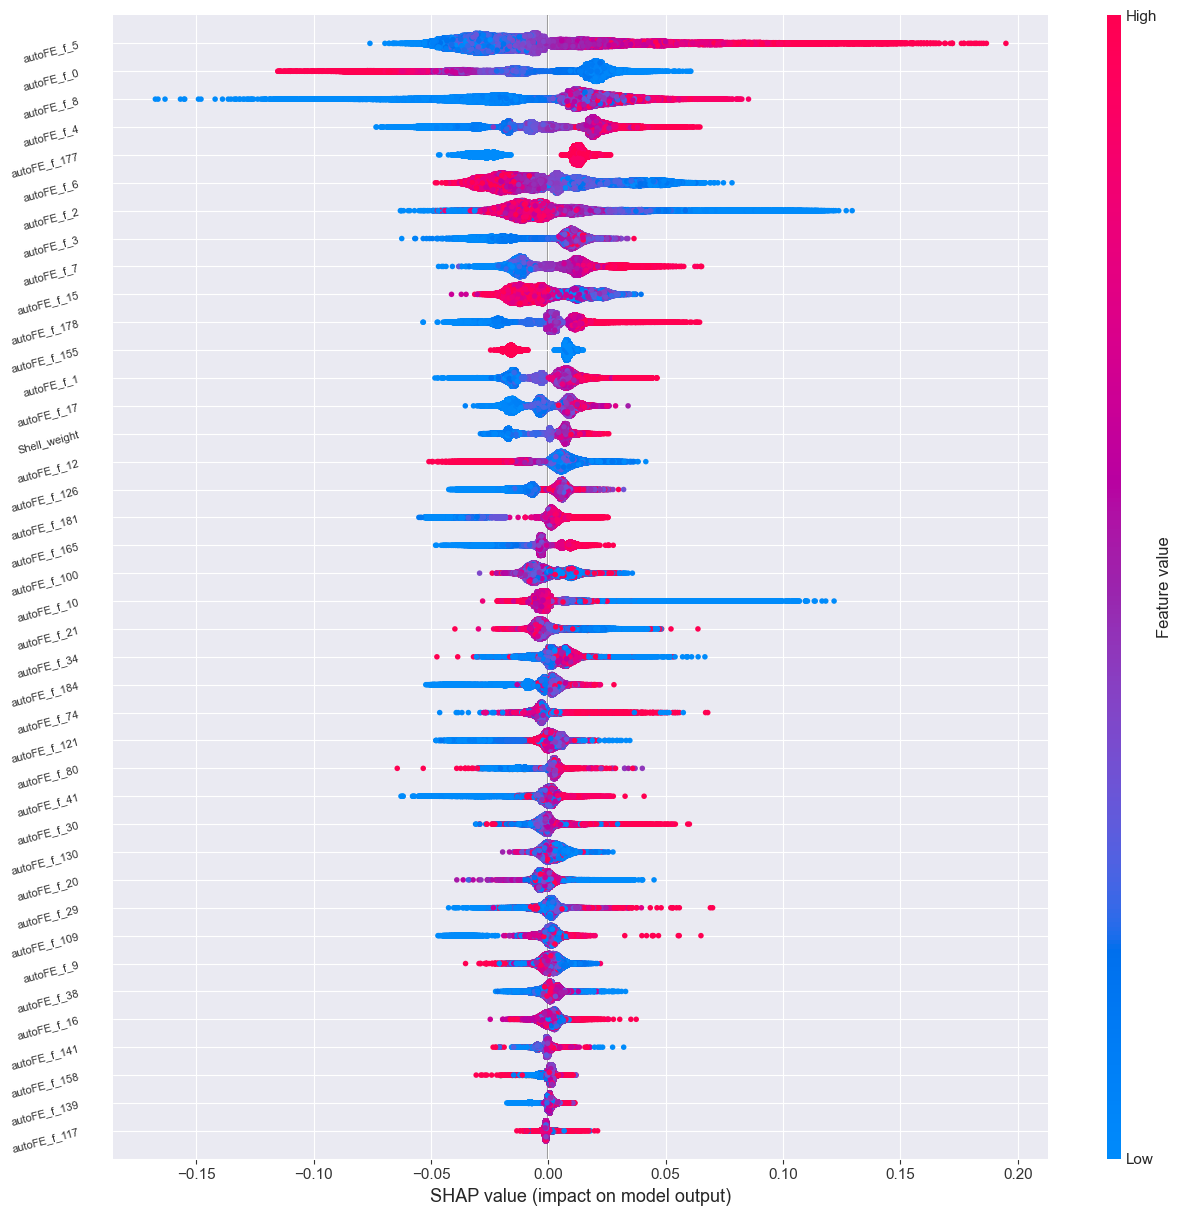

In [35]:
shap_test = shap.TreeExplainer(catboost_model).shap_values(X_valid_FE_proc.drop(columns=["id"]))
shap.summary_plot(shap_test, X_valid_FE_proc.drop(columns=["id"]), max_display=X_valid_FE_proc.shape[1], show=False)

plt.gcf().set_size_inches(15, len(sorted_idx) * 0.3)
plt.yticks(fontsize=8, rotation=15)
plt.show()

In [36]:
features_to_delete = set(["autoFE_f_" + str(feature_num) for feature_num in [117, 158, 16, 38, 9, 109, 20, 130, 30, 80, 121, 74, 34,
                                                                             10, 100, 2, 0]] + [])
importance_df = importance_df[~importance_df["col_name"].isin(features_to_delete)]
print(len(importance_df))
importance_df

23


col_name shap_importance
13     autoFE_f_5        0.028746
11     autoFE_f_3        0.025661
16     autoFE_f_8        0.024201
14     autoFE_f_6        0.021464
15     autoFE_f_7        0.015452
191  autoFE_f_184        0.015129
162  autoFE_f_155        0.012924
23    autoFE_f_15        0.012216
184  autoFE_f_177        0.011902
12     autoFE_f_4         0.01113
9      autoFE_f_1        0.007949
188  autoFE_f_181        0.004633
185  autoFE_f_178        0.004132
25    autoFE_f_17        0.003395
49    autoFE_f_41        0.003338
20    autoFE_f_12        0.003095
172  autoFE_f_165        0.003001
29    autoFE_f_21        0.002875
6    Shell_weight        0.002843
146  autoFE_f_139        0.002815
133  autoFE_f_126        0.002799
148  autoFE_f_141        0.002732
37    autoFE_f_29        0.002708

In [37]:
X_train_CVFE_proc = X_train_CVFE[importance_df["col_name"]]
X_test_CVFE_proc = X_test_CVFE[importance_df["col_name"]]
X_valid_FE_proc = X_valid_FE[importance_df["col_name"].to_list() + ["id"]]

catboost_model = CatBoostRegressor(
    loss_function="RMSE",
    # cat_features=["Sex"]
).fit(X_train_CVFE_proc, y_train_CV)
y_predict = catboost_model.predict(data=X_test_CVFE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(y_predict)):.5f}")

Learning rate set to 0.080066
0:	learn: 0.2702936	total: 2.76ms	remaining: 2.75s
1:	learn: 0.2570489	total: 5.24ms	remaining: 2.62s
2:	learn: 0.2452835	total: 7.34ms	remaining: 2.44s
3:	learn: 0.2345563	total: 9.58ms	remaining: 2.39s
4:	learn: 0.2249822	total: 12ms	remaining: 2.39s
5:	learn: 0.2163997	total: 14.4ms	remaining: 2.38s
6:	learn: 0.2088302	total: 17ms	remaining: 2.42s
7:	learn: 0.2020258	total: 19.5ms	remaining: 2.42s
8:	learn: 0.1960193	total: 22.1ms	remaining: 2.43s
9:	learn: 0.1907378	total: 24.7ms	remaining: 2.45s
10:	learn: 0.1860285	total: 27.2ms	remaining: 2.45s
11:	learn: 0.1818311	total: 29.5ms	remaining: 2.42s
12:	learn: 0.1781600	total: 31.8ms	remaining: 2.41s
13:	learn: 0.1748282	total: 34.1ms	remaining: 2.4s
14:	learn: 0.1718482	total: 36.6ms	remaining: 2.41s
15:	learn: 0.1694254	total: 38.9ms	remaining: 2.39s
16:	learn: 0.1671292	total: 41.3ms	remaining: 2.39s
17:	learn: 0.1652867	total: 43.8ms	remaining: 2.39s
18:	learn: 0.1635791	total: 46ms	remaining: 2.38s

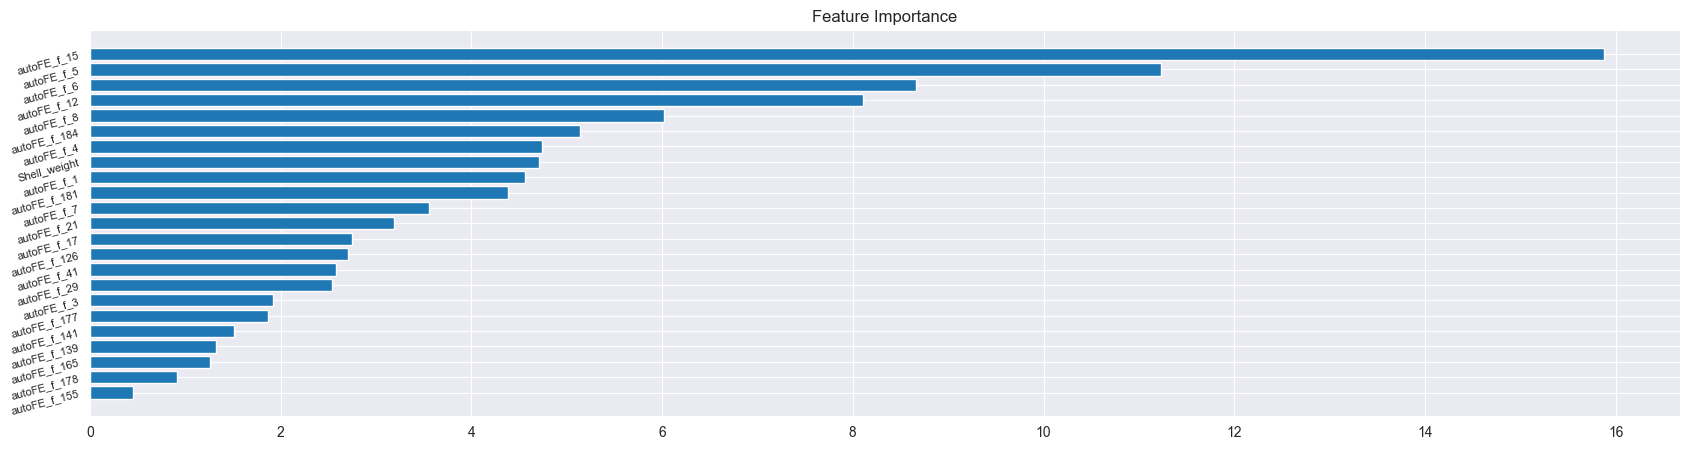

In [38]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(17, len(sorted_idx) * 0.2))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_test_CVFE_proc.columns)[sorted_idx], fontsize=8, rotation=15)
plt.title("Feature Importance")
plt.tight_layout()

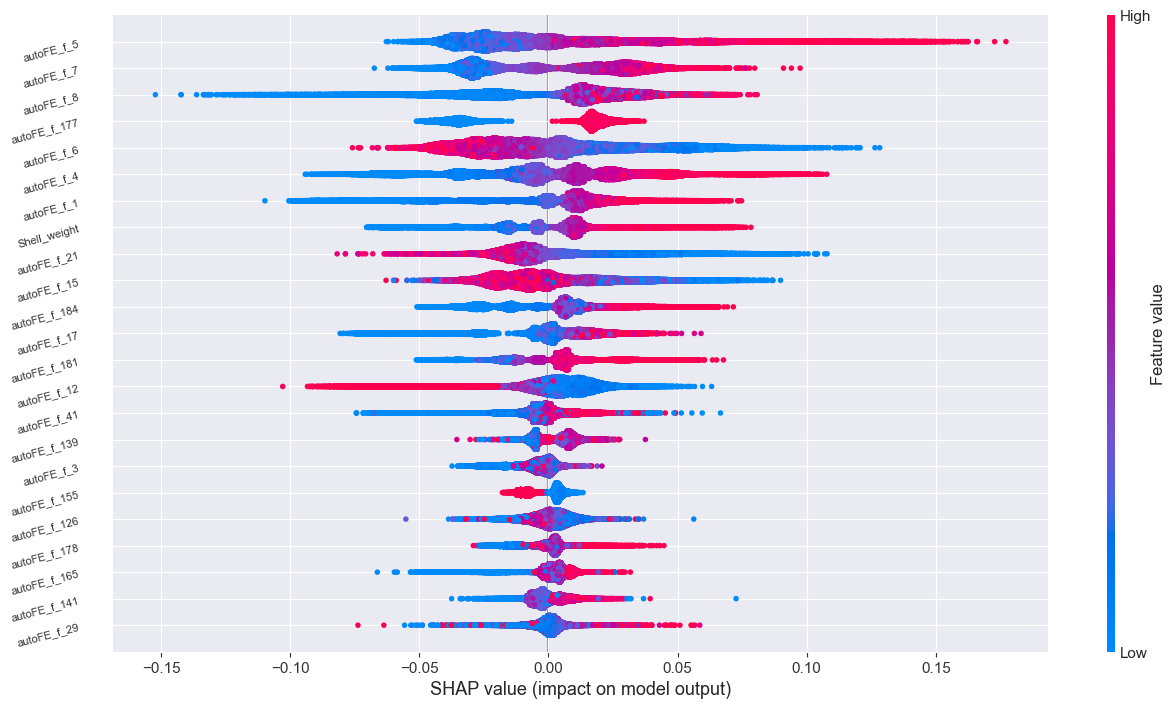

In [39]:
shap_test = shap.TreeExplainer(catboost_model).shap_values(X_valid_FE_proc.drop(columns=["id"]))
shap.summary_plot(shap_test, X_valid_FE_proc.drop(columns=["id"]), max_display=X_test_CVFE_proc.shape[1], show=False)

plt.gcf().set_size_inches(15, len(sorted_idx) * 0.3)
plt.yticks(fontsize=8, rotation=15)
plt.show()

In [44]:
features_to_delete.update(set(["autoFE_f_" + str(feature_num) for feature_num in [126, 184, 29, 17, 141]] + []))
importance_df = importance_df[~importance_df["col_name"].isin(features_to_delete)]
print(len(importance_df))
importance_df

18


col_name shap_importance
13     autoFE_f_5        0.028746
11     autoFE_f_3        0.025661
16     autoFE_f_8        0.024201
14     autoFE_f_6        0.021464
15     autoFE_f_7        0.015452
162  autoFE_f_155        0.012924
23    autoFE_f_15        0.012216
184  autoFE_f_177        0.011902
12     autoFE_f_4         0.01113
9      autoFE_f_1        0.007949
188  autoFE_f_181        0.004633
185  autoFE_f_178        0.004132
49    autoFE_f_41        0.003338
20    autoFE_f_12        0.003095
172  autoFE_f_165        0.003001
29    autoFE_f_21        0.002875
6    Shell_weight        0.002843
146  autoFE_f_139        0.002815

In [45]:
X_train_CVFE_proc = X_train_CVFE[importance_df["col_name"]]
X_test_CVFE_proc = X_test_CVFE[importance_df["col_name"]]
X_valid_FE_proc = X_valid_FE[importance_df["col_name"].to_list() + ["id"]]

catboost_model = CatBoostRegressor(
    loss_function="RMSE",
).fit(X_train_CVFE_proc, y_train_CV)
y_predict = catboost_model.predict(data=X_test_CVFE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(y_predict)):.5f}")

Learning rate set to 0.080066
0:	learn: 0.2703280	total: 3ms	remaining: 2.99s
1:	learn: 0.2569406	total: 5.58ms	remaining: 2.79s
2:	learn: 0.2449115	total: 8.07ms	remaining: 2.68s
3:	learn: 0.2342568	total: 10.2ms	remaining: 2.54s
4:	learn: 0.2247526	total: 12.6ms	remaining: 2.51s
5:	learn: 0.2163698	total: 14.9ms	remaining: 2.47s
6:	learn: 0.2087801	total: 16.7ms	remaining: 2.37s
7:	learn: 0.2020901	total: 18.9ms	remaining: 2.35s
8:	learn: 0.1960126	total: 21.8ms	remaining: 2.4s
9:	learn: 0.1906177	total: 25.1ms	remaining: 2.49s
10:	learn: 0.1858593	total: 27.4ms	remaining: 2.47s
11:	learn: 0.1817946	total: 29.8ms	remaining: 2.45s
12:	learn: 0.1780969	total: 32.2ms	remaining: 2.44s
13:	learn: 0.1748743	total: 34.4ms	remaining: 2.42s
14:	learn: 0.1720864	total: 36.8ms	remaining: 2.42s
15:	learn: 0.1694678	total: 39.2ms	remaining: 2.41s
16:	learn: 0.1672152	total: 41.5ms	remaining: 2.4s
17:	learn: 0.1652199	total: 43.9ms	remaining: 2.39s
18:	learn: 0.1634883	total: 46.2ms	remaining: 2.3

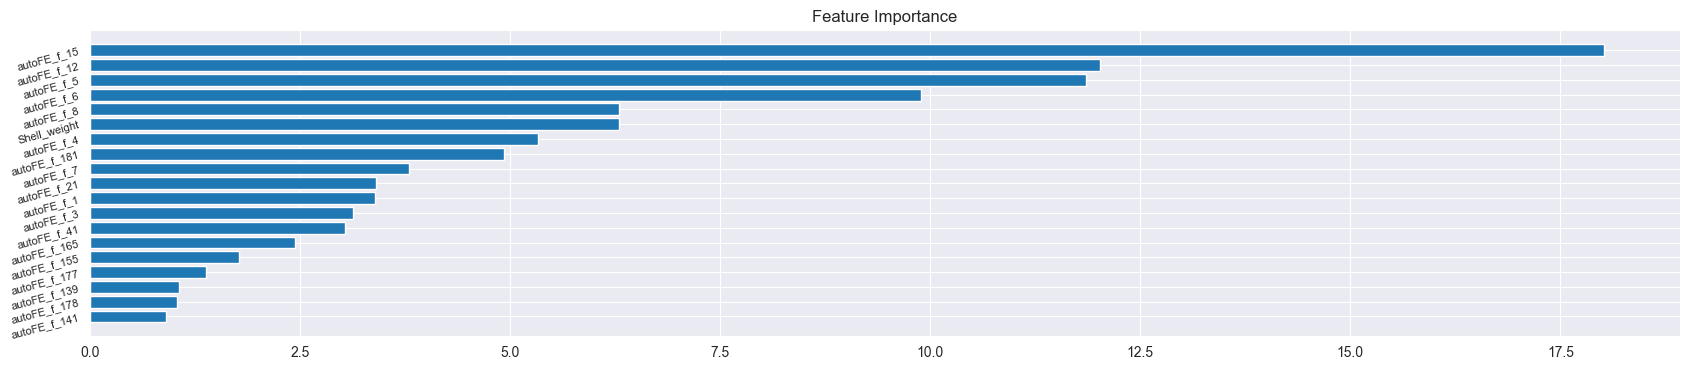

In [42]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(17, len(sorted_idx) * 0.2))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_test_CVFE_proc.columns)[sorted_idx], fontsize=8, rotation=15)
plt.title("Feature Importance")
plt.tight_layout()

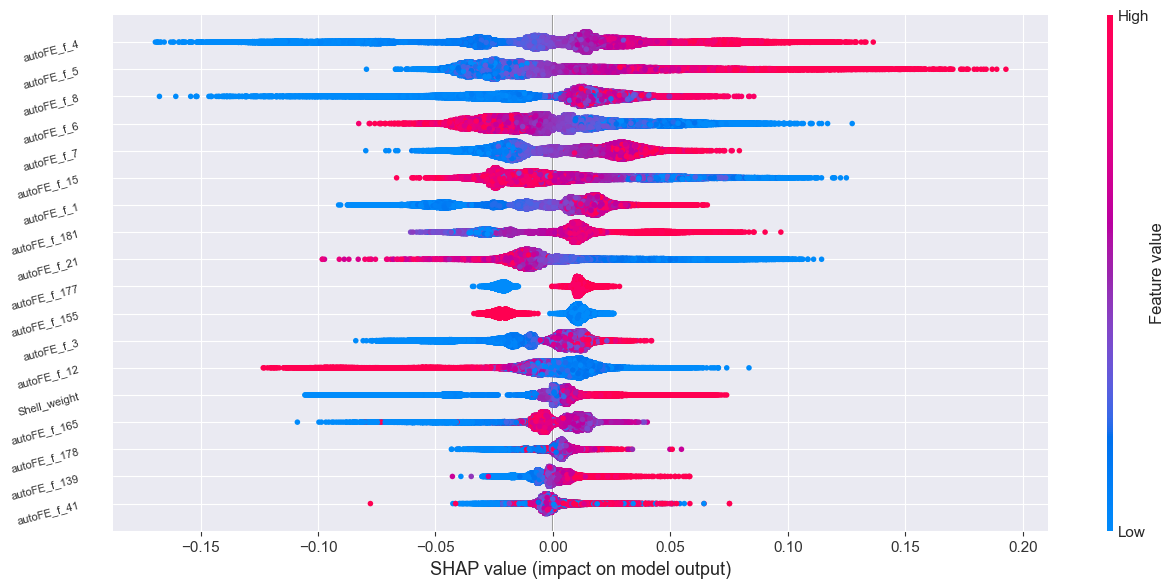

In [46]:
shap_test = shap.TreeExplainer(catboost_model).shap_values(X_valid_FE_proc.drop(columns=["id"]))
shap.summary_plot(shap_test, X_valid_FE_proc.drop(columns=["id"]), max_display=X_test_CVFE_proc.shape[1], show=False)

plt.gcf().set_size_inches(15, len(sorted_idx) * 0.3)
plt.yticks(fontsize=8, rotation=15)
plt.show()

In [ ]:
class ParamsOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.y_train = y_train

        self.X_test = X_test
        self.y_test = y_test
    

    def objective(self, trial):
        catboost_params = {
            "verbose": False,
            "iterations": 1000,
            "loss_function":"RMSE",
            "random_state": RANDOM_SEED,
            "depth": trial.suggest_int("depth", 3, 8),
            "subsample": trial.suggest_float("subsample", 0.01, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 80),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1.0),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "l2_leaf_reg":  trial.suggest_float("l2_leaf_reg", 0, 1),
        }
        
        return self.fit(catboost_params)

    def fit(self, params):

        mskf = KFold(n_splits=10, shuffle=True)
        oof_valid_preds = np.zeros(self.X_train.shape[0])

        for train_idx, valid_idx in mskf.split(self.X_train, self.y_train):
            X_train, y_train = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
            X_valid, y_valid = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

            model = CatBoostRegressor(**params)
            model.fit(X_train, y_train)
        

            valid_preds = model.predict(X_valid)

            oof_valid_preds[valid_idx] = valid_preds

        oof_score = RMSLE(np.expm1(self.y_train), np.expm1(oof_valid_preds))

        return oof_score

    def optimize(self, n_trials=100):
        study = optuna.create_study(direction="minimize", sampler=TPESampler(multivariate=True, n_startup_trials=n_trials), pruner=optuna.pruners.MedianPruner())
        study.optimize(self.objective, timeout=n_trials, n_jobs=4)

        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        return study.best_params


In [ ]:
catboost_optimizer = ParamsOptimizer(X_train=X_train_CVFE_proc, X_test=X_test_CVFE_proc, y_train=y_train_CV, y_test=y_test_CV)
catboost_best_params = catboost_optimizer.optimize(n_trials=50)
catboost_best_params

[I 2024-12-04 15:04:31,222] A new study created in memory with name: no-name-ae405ecd-cfb5-4fc3-9516-03bfa2a4cec3
[I 2024-12-04 15:04:51,475] Trial 3 finished with value: 0.14857572776767092 and parameters: {'depth': 4, 'subsample': 0.2854597960033873, 'min_data_in_leaf': 66, 'colsample_bylevel': 0.3244498443366359, 'learning_rate': 0.092287455408686, 'l2_leaf_reg': 0.416182756316379}. Best is trial 3 with value: 0.14857572776767092.
[I 2024-12-04 15:05:03,724] Trial 1 finished with value: 0.1768723861024891 and parameters: {'depth': 7, 'subsample': 0.20003196418925948, 'min_data_in_leaf': 27, 'colsample_bylevel': 0.6157512638214229, 'learning_rate': 0.001095946484935847, 'l2_leaf_reg': 0.3616122979757286}. Best is trial 3 with value: 0.14857572776767092.
[I 2024-12-04 15:05:08,918] Trial 0 finished with value: 0.14915853255324185 and parameters: {'depth': 6, 'subsample': 0.9282063588911664, 'min_data_in_leaf': 52, 'colsample_bylevel': 0.7474230176348695, 'learning_rate': 0.01032519087

Best trial:
  Value:  0.14830366265363182
  Params: 
    depth: 8
    subsample: 0.2648015321071059
    min_data_in_leaf: 40
    colsample_bylevel: 0.49858463388041263
    learning_rate: 0.02639055007930344
    l2_leaf_reg: 0.7713885197152132


{'depth': 8,
 'subsample': 0.2648015321071059,
 'min_data_in_leaf': 40,
 'colsample_bylevel': 0.49858463388041263,
 'learning_rate': 0.02639055007930344,
 'l2_leaf_reg': 0.7713885197152132}

In [ ]:
catboost_model = CatBoostRegressor(**catboost_best_params).fit(X_train_CVFE_proc, y_train_CV)
catboost_model_predict = catboost_model.predict(data=X_test_CVFE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(catboost_model_predict)):.5f}")

0:	learn: 0.2806364	total: 4.42ms	remaining: 4.42s
1:	learn: 0.2758166	total: 8.44ms	remaining: 4.21s
2:	learn: 0.2711580	total: 12.2ms	remaining: 4.06s
3:	learn: 0.2667149	total: 15.5ms	remaining: 3.87s
4:	learn: 0.2623646	total: 19.5ms	remaining: 3.88s
5:	learn: 0.2580859	total: 22.6ms	remaining: 3.75s
6:	learn: 0.2540181	total: 25.3ms	remaining: 3.59s
7:	learn: 0.2500620	total: 28ms	remaining: 3.48s
8:	learn: 0.2463070	total: 30.6ms	remaining: 3.37s
9:	learn: 0.2426352	total: 34.1ms	remaining: 3.38s
10:	learn: 0.2390653	total: 37.6ms	remaining: 3.38s
11:	learn: 0.2356101	total: 41.1ms	remaining: 3.38s
12:	learn: 0.2322572	total: 45.1ms	remaining: 3.43s
13:	learn: 0.2290483	total: 49.1ms	remaining: 3.46s
14:	learn: 0.2259494	total: 52.5ms	remaining: 3.45s
15:	learn: 0.2229966	total: 56.6ms	remaining: 3.48s
16:	learn: 0.2201285	total: 59.7ms	remaining: 3.45s
17:	learn: 0.2173366	total: 63.8ms	remaining: 3.48s
18:	learn: 0.2146111	total: 67.7ms	remaining: 3.5s
19:	learn: 0.2120611	tota

In [ ]:
class LightGBMOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.y_train = y_train

        self.X_test = X_test
        self.y_test = y_test
    

    def objective(self, trial):

        lightboost_params = {
            "max_depth": trial.suggest_int("max_depth", 2, 13),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "n_estimators": trial.suggest_int("n_estimators", 50, 2500),
            "boosting_type": "gbdt",
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "lambda_l1": trial.suggest_float("lambda_l1", 0, 1),
            "lambda_l2": trial.suggest_float("lambda_l2", 0, 1),
            "min_split_gain": trial.suggest_float("min_split_gain", 0, 1),
            "max_bin": trial.suggest_int("max_bin", 10, 1000),
            "random_state": 42,
            "metric": "rmse",
            "top_rate": trial.suggest_float("top_rate", 0.1, 0.5),
            "other_rate": trial.suggest_float("other_rate", 0.1, 0.5),
            "max_delta_step": trial.suggest_float("max_delta_step", 0, 1),
            "verbosity": -1,
        }
        
        return self.fit(lightboost_params)

    def fit(self, params):

        mskf = KFold(n_splits=10, shuffle=True)
        oof_valid_preds = np.zeros(self.X_train.shape[0])

        for train_idx, valid_idx in mskf.split(self.X_train, self.y_train):
            X_train, y_train = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
            X_valid, y_valid = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

            lightgbm_model = LGBMRegressor(**params)
            lightgbm_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stopping(100)])

            valid_preds = lightgbm_model.predict(X_valid)

            oof_valid_preds[valid_idx] = valid_preds

        oof_score = RMSLE(np.expm1(self.y_train), np.expm1(oof_valid_preds))

        return oof_score

    def optimize(self, n_trials=100):
        study = optuna.create_study(direction="minimize", sampler=TPESampler(multivariate=True, n_startup_trials=n_trials), pruner=optuna.pruners.MedianPruner())
        study.optimize(self.objective, timeout=n_trials, n_jobs=4)

        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        return study.best_params

In [ ]:
lightgbm_optimizer = LightGBMOptimizer(X_train=X_train_CVFE_proc, X_test=X_train_CVFE_proc, y_train=y_train_CV, y_test=y_test_CV)
lightgbm_best_params = lightgbm_optimizer.optimize(n_trials=50)

lightgbm_best_params

[I 2024-12-04 15:06:36,940] A new study created in memory with name: no-name-d86d6856-a6ef-47bd-96d2-8011bd01680e


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[373]	valid_0's rmse: 0.152584
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[370]	valid_0's rmse: 0.149114
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	valid_0's rmse: 0.151401
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[370]	valid_0's rmse: 0.151138
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[709]	valid_0's rmse: 0.147617
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[373]	valid_0's rmse: 0.151032
Training until validation scores don't improve

[I 2024-12-04 15:06:48,825] Trial 0 finished with value: 0.14982677787685755 and parameters: {'max_depth': 9, 'num_leaves': 100, 'learning_rate': 0.08111583050824986, 'n_estimators': 1221, 'min_child_samples': 1, 'feature_fraction': 0.11700921736098334, 'subsample': 0.7957139545260656, 'colsample_bytree': 0.7209953064443815, 'lambda_l1': 0.14815702699931366, 'lambda_l2': 0.26872398817413234, 'min_split_gain': 0.35170074014305985, 'max_bin': 793, 'top_rate': 0.36235247362316614, 'other_rate': 0.10250877126553687, 'max_delta_step': 0.3452436969946967}. Best is trial 0 with value: 0.14982677787685755.


Early stopping, best iteration is:
[373]	valid_0's rmse: 0.14533
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[835]	valid_0's rmse: 0.186397
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[701]	valid_0's rmse: 0.152361
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[702]	valid_0's rmse: 0.149956
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[702]	valid_0's rmse: 0.145811
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2404]	valid_0's rmse: 0.153114
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[702]	valid_0's rmse: 0.150625
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[835]	valid_0's rmse: 0.1908
T

[I 2024-12-04 15:07:15,816] Trial 3 finished with value: 0.14975221957259105 and parameters: {'max_depth': 7, 'num_leaves': 12, 'learning_rate': 0.010158415207104187, 'n_estimators': 2123, 'min_child_samples': 44, 'feature_fraction': 0.6127281229817996, 'subsample': 0.6703794335505149, 'colsample_bytree': 0.9662075357085016, 'lambda_l1': 0.689405426833758, 'lambda_l2': 0.9247539968389641, 'min_split_gain': 0.44362415707869185, 'max_bin': 445, 'top_rate': 0.36430280806365833, 'other_rate': 0.4573628033534528, 'max_delta_step': 0.11217936163559794}. Best is trial 3 with value: 0.14975221957259105.


Early stopping, best iteration is:
[705]	valid_0's rmse: 0.152951
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[672]	valid_0's rmse: 0.146292
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2404]	valid_0's rmse: 0.151522
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[835]	valid_0's rmse: 0.196547
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[672]	valid_0's rmse: 0.148556
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[672]	valid_0's rmse: 0.149452
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2404]	valid_0's rmse: 0.153863
Training until validation scores don't improve for 100 rounds
Did not meet early stopp

[I 2024-12-04 15:08:23,343] Trial 5 finished with value: 0.1495229661462396 and parameters: {'max_depth': 13, 'num_leaves': 73, 'learning_rate': 0.0071022692294641756, 'n_estimators': 672, 'min_child_samples': 70, 'feature_fraction': 0.2818091414378381, 'subsample': 0.824716449780885, 'colsample_bytree': 0.667740600939984, 'lambda_l1': 0.1941639634588731, 'lambda_l2': 0.7839138566696834, 'min_split_gain': 0.5088267087269738, 'max_bin': 355, 'top_rate': 0.2168608708506033, 'other_rate': 0.42811233265155035, 'max_delta_step': 0.4680238520434097}. Best is trial 5 with value: 0.1495229661462396.


Did not meet early stopping. Best iteration is:
[672]	valid_0's rmse: 0.148125
Did not meet early stopping. Best iteration is:
[2404]	valid_0's rmse: 0.153701
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[835]	valid_0's rmse: 0.182825
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2404]	valid_0's rmse: 0.155911
Training until validation scores don't improve for 100 rounds


[I 2024-12-04 15:08:40,459] Trial 2 finished with value: 0.18803302215581458 and parameters: {'max_depth': 13, 'num_leaves': 239, 'learning_rate': 0.0011681333148910232, 'n_estimators': 835, 'min_child_samples': 83, 'feature_fraction': 0.11505070852048246, 'subsample': 0.766849698017811, 'colsample_bytree': 0.8533942621295361, 'lambda_l1': 0.8633074022392934, 'lambda_l2': 0.21021575326364572, 'min_split_gain': 0.9424843749201032, 'max_bin': 936, 'top_rate': 0.3298333479859018, 'other_rate': 0.4685212171990074, 'max_delta_step': 0.887886815857566}. Best is trial 5 with value: 0.1495229661462396.


Did not meet early stopping. Best iteration is:
[835]	valid_0's rmse: 0.185179
Did not meet early stopping. Best iteration is:
[1829]	valid_0's rmse: 0.153834
Training until validation scores don't improve for 100 rounds


[I 2024-12-04 15:08:45,727] Trial 4 finished with value: 0.15234203206671096 and parameters: {'max_depth': 4, 'num_leaves': 131, 'learning_rate': 0.0014628428541007307, 'n_estimators': 2404, 'min_child_samples': 11, 'feature_fraction': 0.28449159924956247, 'subsample': 0.5927079526762136, 'colsample_bytree': 0.974237562478957, 'lambda_l1': 0.07955708639548453, 'lambda_l2': 0.4957713136360197, 'min_split_gain': 0.6980615192613316, 'max_bin': 26, 'top_rate': 0.267455993590525, 'other_rate': 0.2381548805675945, 'max_delta_step': 0.5344547800673825}. Best is trial 5 with value: 0.1495229661462396.


Did not meet early stopping. Best iteration is:
[2404]	valid_0's rmse: 0.147948
Did not meet early stopping. Best iteration is:
[1829]	valid_0's rmse: 0.155876
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1829]	valid_0's rmse: 0.155095
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1829]	valid_0's rmse: 0.159338
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1829]	valid_0's rmse: 0.150047
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1829]	valid_0's rmse: 0.151884
Training until validation scores don't improve for 100 rounds


[I 2024-12-04 15:10:03,671] Trial 1 finished with value: 0.15443172661237517 and parameters: {'max_depth': 13, 'num_leaves': 253, 'learning_rate': 0.012247595739407799, 'n_estimators': 1829, 'min_child_samples': 46, 'feature_fraction': 0.3519652623786812, 'subsample': 0.7533590853725143, 'colsample_bytree': 0.923218525014275, 'lambda_l1': 0.6067610803589374, 'lambda_l2': 0.7042455344073157, 'min_split_gain': 0.03406941543190256, 'max_bin': 996, 'top_rate': 0.24566706042880068, 'other_rate': 0.3116018092325972, 'max_delta_step': 0.019319764418520347}. Best is trial 5 with value: 0.1495229661462396.


Did not meet early stopping. Best iteration is:
[1829]	valid_0's rmse: 0.154101
Best trial:
  Value:  0.1495229661462396
  Params: 
    max_depth: 13
    num_leaves: 73
    learning_rate: 0.0071022692294641756
    n_estimators: 672
    min_child_samples: 70
    feature_fraction: 0.2818091414378381
    subsample: 0.824716449780885
    colsample_bytree: 0.667740600939984
    lambda_l1: 0.1941639634588731
    lambda_l2: 0.7839138566696834
    min_split_gain: 0.5088267087269738
    max_bin: 355
    top_rate: 0.2168608708506033
    other_rate: 0.42811233265155035
    max_delta_step: 0.4680238520434097


{'max_depth': 13,
 'num_leaves': 73,
 'learning_rate': 0.0071022692294641756,
 'n_estimators': 672,
 'min_child_samples': 70,
 'feature_fraction': 0.2818091414378381,
 'subsample': 0.824716449780885,
 'colsample_bytree': 0.667740600939984,
 'lambda_l1': 0.1941639634588731,
 'lambda_l2': 0.7839138566696834,
 'min_split_gain': 0.5088267087269738,
 'max_bin': 355,
 'top_rate': 0.2168608708506033,
 'other_rate': 0.42811233265155035,
 'max_delta_step': 0.4680238520434097}

In [ ]:
lightboost_model = LGBMRegressor(**lightgbm_best_params).fit(X_train_CVFE_proc, y_train_CV)
lightboost_model_predict = lightboost_model.predict(X_test_CVFE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(lightboost_model_predict)):.5f}")

[LightGBM] [Warning] lambda_l1 is set=0.1941639634588731, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1941639634588731
[LightGBM] [Warning] lambda_l2 is set=0.7839138566696834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7839138566696834
[LightGBM] [Warning] feature_fraction is set=0.2818091414378381, colsample_bytree=0.667740600939984 will be ignored. Current value: feature_fraction=0.2818091414378381
[LightGBM] [Warning] lambda_l1 is set=0.1941639634588731, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1941639634588731
[LightGBM] [Warning] lambda_l2 is set=0.7839138566696834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7839138566696834
[LightGBM] [Warning] feature_fraction is set=0.2818091414378381, colsample_bytree=0.667740600939984 will be ignored. Current value: feature_fraction=0.2818091414378381
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_col_wis

In [ ]:
class ParamsOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.y_train = y_train

        self.X_test = X_test
        self.y_test = y_test
    

    def objective(self, trial):

        xgboost_params = {
            "eval_metric": "rmse",
            "random_state": RANDOM_SEED,
            "objective": "reg:squarederror",
            "gamma": trial.suggest_float("gamma", 1e-2, 1.0),
            "max_depth": trial.suggest_int("max_depth",2, 20),
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            "n_estimators": trial.suggest_int("n_estimators",100, 1000),
            "min_child_weight": trial.suggest_int("min_child_weight",2, 20),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        }
        
        return self.fit(xgboost_params)

    def fit(self, params):
        mskf = KFold(n_splits=10, shuffle=True)
        oof_valid_preds = np.zeros(self.X_train.shape[0])

        for train_idx, valid_idx in mskf.split(self.X_train, self.y_train):
            X_train, y_train = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
            X_valid, _ = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

            xgboost_model = XGBRegressor(**params)
            xgboost_model.fit(X_train, y_train)

            valid_preds = xgboost_model.predict(X_valid)

            oof_valid_preds[valid_idx] = valid_preds

        oof_score = RMSLE(np.expm1(self.y_train), np.expm1(oof_valid_preds))

        return oof_score

    def optimize(self, n_trials=100):
        study = optuna.create_study(direction="minimize", sampler=TPESampler(multivariate=True, n_startup_trials=n_trials))
        study.optimize(self.objective, timeout=n_trials, n_jobs=4)

        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        return study.best_params

In [ ]:
xgboost_optimizer = ParamsOptimizer(X_train=X_train_CVFE_proc, X_test=X_test_CVFE_proc, y_train=y_train_CV, y_test=y_test_CV)
xgboost_best_params = xgboost_optimizer.optimize(n_trials=50)
xgboost_best_params

[I 2024-12-04 15:13:12,571] A new study created in memory with name: no-name-177b7e33-866b-4279-a2dd-788f92168ff0
[I 2024-12-04 15:13:26,341] Trial 2 finished with value: 0.20396402503905542 and parameters: {'gamma': 0.6765115989232732, 'max_depth': 7, 'subsample': 0.6391278463276187, 'n_estimators': 216, 'min_child_weight': 13, 'colsample_bytree': 0.25593592075493454, 'learning_rate': 0.0030075033994278523}. Best is trial 2 with value: 0.20396402503905542.
[I 2024-12-04 15:13:30,768] Trial 0 finished with value: 0.15006807423103408 and parameters: {'gamma': 0.4279807116988954, 'max_depth': 11, 'subsample': 0.07871288118970912, 'n_estimators': 818, 'min_child_weight': 19, 'colsample_bytree': 0.44857902874681066, 'learning_rate': 0.014926263565956248}. Best is trial 0 with value: 0.15006807423103408.
[I 2024-12-04 15:13:44,895] Trial 5 finished with value: 0.1580508731336192 and parameters: {'gamma': 0.4280547823371031, 'max_depth': 5, 'subsample': 0.599178241504144, 'n_estimators': 309

Best trial:
  Value:  0.14873876230993116
  Params: 
    gamma: 0.0548268309824776
    max_depth: 19
    subsample: 0.8064381553224129
    n_estimators: 984
    min_child_weight: 16
    colsample_bytree: 0.7352619535406216
    learning_rate: 0.007187301526093418


{'gamma': 0.0548268309824776,
 'max_depth': 19,
 'subsample': 0.8064381553224129,
 'n_estimators': 984,
 'min_child_weight': 16,
 'colsample_bytree': 0.7352619535406216,
 'learning_rate': 0.007187301526093418}

In [ ]:
xgboost_model = XGBRegressor(**xgboost_best_params).fit(X_train_CVFE_proc, y_train_CV)
xgboost_model_predict = xgboost_model.predict(X_test_CVFE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(xgboost_model_predict)):.5f}")

RMSLE loss = 0.14780


### Voting

In [ ]:
class VotingOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test, estimators):
        self.X_train = X_train
        self.y_train = y_train

        self.X_test = X_test
        self.y_test = y_test

        self.estimators = estimators
    
    def objective(self, trial):

        params = {
            "LGBM_weight": trial.suggest_float("LGBM_weight", 0.0, 5.0),
            "XGBoost_weight": trial.suggest_float("XGBoost_weight", 0.0, 5.0),
            "CatBoost_weight": trial.suggest_float("CatBoost_weight", 0.0, 5.0),
        }
        
        return self.fit(params)

    def fit(self, params):
        mskf = KFold(n_splits=5, shuffle=True)
        oof_valid_preds = np.zeros(self.X_train.shape[0])

        for train_idx, valid_idx in mskf.split(self.X_train, self.y_train):
            X_train, y_train = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
            X_valid, _ = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

            voting_regressor = VotingRegressor(
                estimators=self.estimators,
                weights=[params["LGBM_weight"], params["XGBoost_weight"], params["CatBoost_weight"]]
            )
            voting_regressor.fit(X_train, y_train)
            valid_preds = voting_regressor.predict(X_valid)

            oof_valid_preds[valid_idx] = valid_preds
            
        oof_score = RMSLE(np.expm1(self.y_train), np.expm1(oof_valid_preds))
        return oof_score

    

    def optimize(self, n_trials=100):
        study = optuna.create_study(direction="minimize")
        study.optimize(self.objective, timeout=n_trials, n_jobs=4)

        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        return study.best_params

catboost_best_params["verbose"] = False
lightgbm_best_params["verbosity"]= -1

estimators = [
    ("LightGBM", LGBMRegressor(**lightgbm_best_params)),
    ("XGBoost", XGBRegressor(**xgboost_best_params)),
    ("CatBoost", CatBoostRegressor(**catboost_best_params)),
]

voting_optimizer = VotingOptimizer(X_train=X_train_CVFE_proc, X_test=X_test_CVFE_proc, y_train=y_train_CV, y_test=y_test_CV, estimators=estimators)
voting_optimizer_best_params = voting_optimizer.optimize(n_trials=50)
voting_optimizer_best_params

[I 2024-12-04 15:16:05,849] A new study created in memory with name: no-name-a1592542-3384-4e29-a77a-6032150beeb9
[I 2024-12-04 15:18:03,159] Trial 2 finished with value: 0.14820078304187367 and parameters: {'LGBM_weight': 0.9604116697770737, 'XGBoost_weight': 3.248762222809699, 'CatBoost_weight': 3.386038284294698}. Best is trial 2 with value: 0.14820078304187367.
[I 2024-12-04 15:18:05,914] Trial 3 finished with value: 0.14834801969199649 and parameters: {'LGBM_weight': 2.4345574657076163, 'XGBoost_weight': 3.684180909156434, 'CatBoost_weight': 1.1723604766882467}. Best is trial 2 with value: 0.14820078304187367.
[I 2024-12-04 15:18:06,106] Trial 1 finished with value: 0.14835803978887022 and parameters: {'LGBM_weight': 4.01768836864464, 'XGBoost_weight': 4.413984405141987, 'CatBoost_weight': 1.1707931153330526}. Best is trial 2 with value: 0.14820078304187367.
[I 2024-12-04 15:18:06,521] Trial 0 finished with value: 0.14815086658335272 and parameters: {'LGBM_weight': 1.5414925011952

Best trial:
  Value:  0.14815086658335272
  Params: 
    LGBM_weight: 1.5414925011952967
    XGBoost_weight: 2.5603395287783517
    CatBoost_weight: 2.910780172083954


{'LGBM_weight': 1.5414925011952967,
 'XGBoost_weight': 2.5603395287783517,
 'CatBoost_weight': 2.910780172083954}

In [ ]:
voting_ensible = VotingRegressor(
    estimators=estimators,
    weights=voting_optimizer_best_params.values(),
).fit(X_train_CVFE_proc, y_train_CV)
voting_ensible_predict = voting_ensible.predict(X_test_CVFE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(voting_ensible_predict)):.5f}")

RMSLE loss = 0.14734


In [110]:
X, y = pd.concat([X_train_CVFE_proc, X_test_CVFE_proc], ignore_index=True), pd.concat([y_train_CV, y_test_CV], ignore_index=True)
voting_ensible = VotingRegressor(
    estimators=estimators,
    weights=voting_optimizer_best_params.values(),
).fit(X, y)
ans = voting_ensible.predict(X_valid_FE_proc.drop(columns=["id"]))

with open("ans.csv", "w") as f:
    for row_num in range(len(ans)):
        f.write(f"{X_valid_FE_proc["id"].iloc[row_num]},{ans[row_num]}\n")


In [ ]:
class StackingOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test, estimators):
        self.X_train = X_train
        self.y_train = y_train

        self.X_test = X_test
        self.y_test = y_test

        self.estimators = estimators
    

    def objective(self, trial):
        catboost_params = {
            "verbose": False,
            "iterations": 1000,
            "loss_function":"RMSE",
            "random_state": RANDOM_SEED,
            "depth": trial.suggest_int("depth", 3, 8),
            "subsample": trial.suggest_float("subsample", 0.01, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 80),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1.0),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "l2_leaf_reg":  trial.suggest_float("l2_leaf_reg", 0, 1),
        }
        
        return self.fit(catboost_params)

    def fit(self, params):
        mskf = KFold(n_splits=5, shuffle=True)
        oof_valid_preds = np.zeros(self.X_train.shape[0])

        for train_idx, valid_idx in mskf.split(self.X_train, self.y_train):
            X_train, y_train = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
            X_valid, _ = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

            stacking_regressor = StackingRegressor(
                estimators=self.estimators,
                final_estimator=CatBoostRegressor(**params),
            )
            stacking_regressor.fit(X_train, y_train)
            valid_preds = stacking_regressor.predict(X_valid)

            oof_valid_preds[valid_idx] = valid_preds
            
        oof_score = RMSLE(np.expm1(self.y_train), np.expm1(oof_valid_preds))
        return oof_score

    

    def optimize(self, n_trials=100):
        study = optuna.create_study(direction="minimize")
        study.optimize(self.objective, timeout=n_trials, n_jobs=4)

        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        return study.best_params


estimators = [
    ("LightGBM", LGBMRegressor(**lightgbm_best_params)),
    ("XGBoost", XGBRegressor(**xgboost_best_params)),
    ("CatBoost", CatBoostRegressor(**catboost_best_params)),
]

stacking_optimizer = StackingOptimizer(X_train=X_train_CVFE_proc, X_test=X_test_CVFE_proc, y_train=y_train_CV, y_test=y_test_CV, estimators=estimators)
stacking_optimizer_best_params = stacking_optimizer.optimize(n_trials=50)
stacking_optimizer_best_params

[I 2024-12-04 15:19:24,319] A new study created in memory with name: no-name-178ea994-5392-4229-8fdc-dd1d06e14360


KeyboardInterrupt: 

[I 2024-12-04 15:31:50,399] Trial 2 finished with value: 0.1492985260824047 and parameters: {'depth': 9, 'subsample': 0.37173420637611154, 'min_data_in_leaf': 48, 'colsample_bylevel': 0.1501152542030892, 'learning_rate': 0.01417463763826007, 'l2_leaf_reg': 0.42682573786361244}. Best is trial 2 with value: 0.1492985260824047.
[I 2024-12-04 15:31:52,221] Trial 0 finished with value: 0.2238115108397263 and parameters: {'depth': 13, 'subsample': 0.5772520304665659, 'min_data_in_leaf': 1, 'colsample_bylevel': 0.018699488671740587, 'learning_rate': 0.014181166577280205, 'l2_leaf_reg': 0.9244567090554414}. Best is trial 2 with value: 0.1492985260824047.
[I 2024-12-04 15:31:58,534] Trial 3 finished with value: 0.1558672753079926 and parameters: {'depth': 8, 'subsample': 0.49514993367951216, 'min_data_in_leaf': 29, 'colsample_bylevel': 0.48213989078160346, 'learning_rate': 0.00222711706642467, 'l2_leaf_reg': 0.15368738359938738}. Best is trial 2 with value: 0.1492985260824047.
[I 2024-12-04 15:

In [ ]:
stacking_ensible = StackingRegressor(
    estimators=estimators,
    final_estimator=CatBoostRegressor(**stacking_optimizer_best_params),
).fit(X_train_FE_proc, y_train)
stacking_ensible_predict = voting_ensible.predict(X_test_FE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test), np.expm1(stacking_ensible_predict)):.5f}")

0:	learn: 0.2837911	total: 1.14ms	remaining: 1.14s
1:	learn: 0.2823094	total: 3.72ms	remaining: 1.86s
2:	learn: 0.2808360	total: 6.92ms	remaining: 2.3s
3:	learn: 0.2793746	total: 10.2ms	remaining: 2.53s
4:	learn: 0.2784923	total: 10.8ms	remaining: 2.16s
5:	learn: 0.2770451	total: 14.1ms	remaining: 2.33s
6:	learn: 0.2761741	total: 14.8ms	remaining: 2.1s
7:	learn: 0.2749018	total: 15.8ms	remaining: 1.96s
8:	learn: 0.2734914	total: 19.1ms	remaining: 2.1s
9:	learn: 0.2720942	total: 22.1ms	remaining: 2.19s
10:	learn: 0.2707128	total: 25ms	remaining: 2.25s
11:	learn: 0.2693476	total: 27.9ms	remaining: 2.3s
12:	learn: 0.2679928	total: 30.6ms	remaining: 2.33s
13:	learn: 0.2666654	total: 32.6ms	remaining: 2.29s
14:	learn: 0.2658680	total: 33.2ms	remaining: 2.18s
15:	learn: 0.2650754	total: 34ms	remaining: 2.09s
16:	learn: 0.2637596	total: 37.1ms	remaining: 2.15s
17:	learn: 0.2625112	total: 38.5ms	remaining: 2.1s
18:	learn: 0.2612156	total: 42.3ms	remaining: 2.19s
19:	learn: 0.2600706	total: 43.